In [1]:
# Goal:
# Building, Training and testing Neural Network from scracth like Pytorch
# Building pytorch like library
# I will call this project as opengrad
# Will be keep improving this project and keep adding new features in the future
# This notebook is just for learning for opengrad will create a new repo
# It will be fun side project just for learning and sharing purpose


# Motivation / Source
# Ref of this Learning is from micrograd and Tinygrad

# Theory
# Automatic Gradient df/dx
# Auto grad is what you need to train neural networks and everything else is efficiency
# Bacpropagation auto grad engine - Gives power to neural networks
# nn library
# Neuron, Layer, perceptron
# Differentiation is just rate of change
# My understanding - changing something to see output changes/behaves on that change - kind of like a attention
# I can see the attention mechanism from here only change if you get right attention then keep changing in that direction
# To improve you prediction 
# Will see that in future that my understanding is correct or not

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

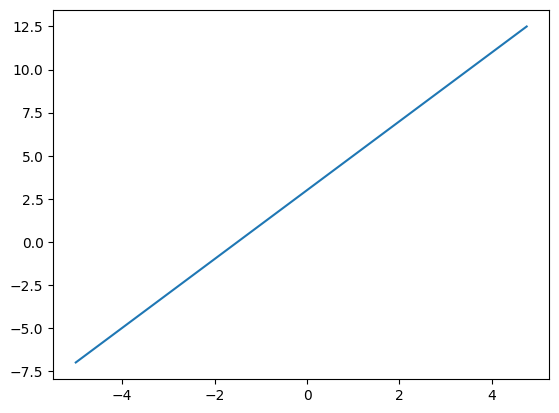

In [3]:
# Differentiaion of the equation
# (f(a + h) - f(a)) / h ; h -> 0

def f1(x):
    return 2 * x + 3
x1_s = np.arange(-5, 5, 0.25)
y1_s = f1(x1_s)
plt.plot(x1_s, y1_s)


In [4]:
def f(x):
    return 2 * x**2 - 3 * x + 2
f(4.0)

22.0

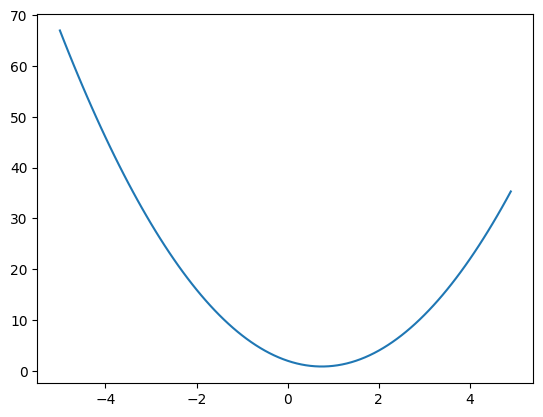

In [5]:
xs = np.arange(-5, 5, 0.1)
xs
ys = f(xs)
ys
plt.plot(xs, ys)

In [6]:
x = 4.0
h = 0.00001
print(f(x))
(f(x + h) - f(x)) / h 

22.0


13.000019999154231

In [7]:
# Equation with multiple variable
h = 0.00001
a = 2
b = -3
c = 10
d1 = a * b + c

a += h
d2 = a * b + c
print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"Slope: {(d2 - d1) / h}")

d1: 4
d2: 3.9999699999999994
Slope: -3.000000000064062


In [8]:
class Value:
    def __init__(self, data, _children=(), op='', label=""):
        self.data = data
        self._prev = set(_children)
        self._op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # Plus node propagates the same gradient to parent node
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        # multiplication other node data * out grad 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out        
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f"**{other}")
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other, self # supports 2 * Value(3.0)
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # Self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [9]:
a = Value(2.0, label= 'a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label= 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
a / 2

Value(data=1.0)

In [10]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [11]:
d._op

'+'

In [12]:
# Build grahp visualizer
# Expression Graph

from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

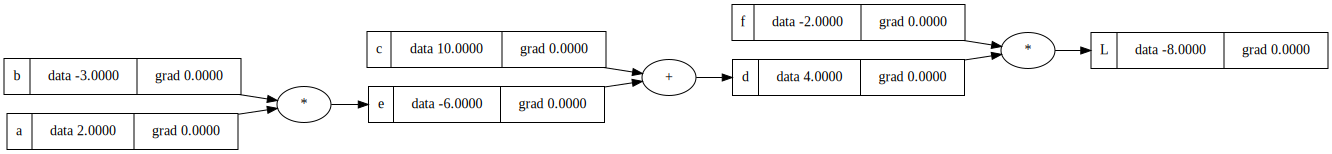

In [13]:
draw_dot(L)

In [14]:
# Now calculate the gradient descent of nodes / Back Propagation
#  dL / dd
L.backward()

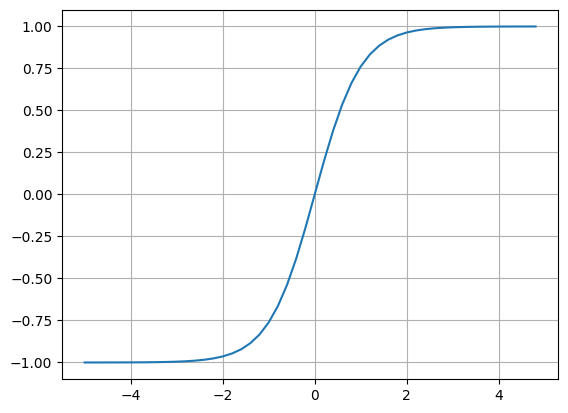

In [15]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

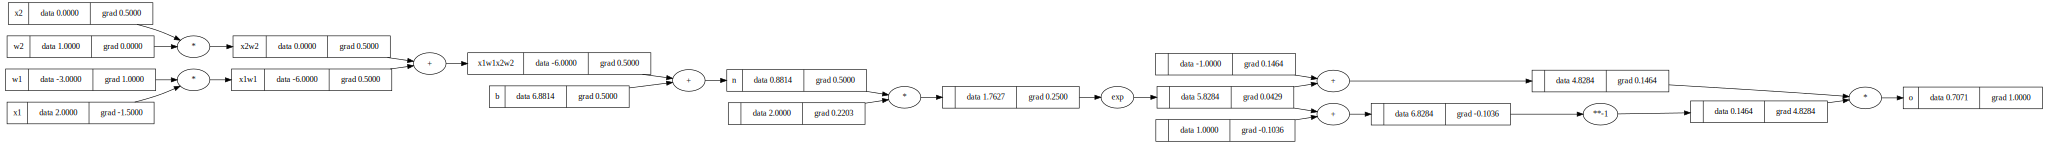

In [16]:
# Single Neuron

# Input data
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the Neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'
# ---
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ---
o.label  = 'o'
o.backward()
draw_dot(o)

In [17]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [18]:
# Tensors are n dimensionals of arrays of scalar
# Multiple Layer Perceptron
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()]
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin]  + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.48653629129408976)

In [19]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):

    # Forward Pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0 # updating the grad to zero, for new backward pass to run with new loss
    loss.backward()

    # Update parameters with new grad 
    # learning rate
    learning_rate = -0.1
    for p in n.parameters():
        p.data += learning_rate * p.grad
    
    print(k, loss.data)

0 0.07232942316637374
1 0.06318505646777026
2 0.05595616614803472
3 0.050112261539008156
4 0.045299758741920805
5 0.041274458818572245
6 0.03786260978695357
7 0.03493741258559225
8 0.03240429257899425
9 0.030191358336745872
10 0.028243042421424783
11 0.026515756058752324
12 0.024974853846781157
13 0.02359247161217256
14 0.022345958973988653
15 0.021216724925792577
16 0.020189375337843558
17 0.01925106010287408
18 0.018390973042171917
19 0.01759996461383331


In [23]:
ypred

[Value(data=0.9542549528986445),
 Value(data=-0.9671363111898846),
 Value(data=-0.9105639018611877),
 Value(data=0.9198219631880107)]